## Import necessary python libraries

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Plot histogram of a image with a specified range

In [2]:
def gen_hist_index(h, i, j, size, band):
    return cv2.calcHist([h[i:i+size, j:j+size]],[band],None,[256],[0,256])/255

## Plot histogram of the whole image

In [3]:
def gen_hist(h, band):
    return cv2.calcHist([h],[band],None,[256],[0,256])/255

## Resize the original image in JPG format to a smaller size (approximately 30%)

In [4]:
def resize(img):
    scale_percent = 30 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    converted = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    return converted

## Resize the original ground mask in TIF format to a smaller size (same as the resized original image)

In [5]:
def resize_tif(img):
    scale_percent = 30 # percent of original size
    width = int(img.size[1] * scale_percent / 100)
    height = int(img.size[0] * scale_percent / 100)
    dim = (height, width)

    resized = img.resize(dim, Image.NEAREST)
    data = np.asarray(resized)
    return data

# Need to change directory path if you tested on your own laptop
## Process retinal images and ground masks

In [6]:
images_list = [cv2.imread(file) for file in sorted(glob.glob("Data_Individual_Component/original_retinal_images/*.jpg"))]
mask_list = [Image.open(file) for file in sorted(glob.glob("Data_Individual_Component/optic_disc_segmentation_masks/*.tif"))]

In [7]:
img_list = []
for img in images_list:
    re = resize(img)
    img_list.append(re)

In [10]:
masks = []
for img in mask_list:
    new = resize_tif(img)
    masks.append(new)

## Select nine images to generate the optis disc histogram template

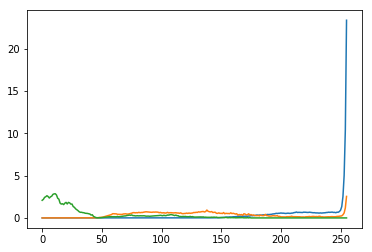

In [11]:
# choose nine images
img1 = img_list[0]
img2 = img_list[4]
img3 = img_list[6]
img4 = img_list[8]
img5 = img_list[16]
img6 = img_list[19]
img7 = img_list[24]
img8 = img_list[34]
img9 = img_list[41]

# template window size: 150*150
# locate at the center of the optic disc
optic1 = img1[345:495, 900:1050]
optic2 = img2[345:495, 810:960]
optic3 = img3[425:575, 860:1010]
optic4 = img4[300:450, 870:1020]
optic5 = img5[350:500, 795:945]
optic6 = img6[370:520, 750:900]
optic7 = img7[335:485, 255:405]
optic8 = img8[315:465, 250:400]
optic9 = img9[360:510, 240:390]

# plot the histogram of each three color band
hist_r1 = gen_hist(optic1, 0)
hist_g1 = gen_hist(optic1, 1)
hist_b1 = gen_hist(optic1, 2)

hist_r2 = gen_hist(optic2, 0)
hist_g2 = gen_hist(optic2, 1)
hist_b2 = gen_hist(optic2, 2)

hist_r3 = gen_hist(optic3, 0)
hist_g3 = gen_hist(optic3, 1)
hist_b3 = gen_hist(optic3, 2)

hist_r4 = gen_hist(optic4, 0)
hist_g4 = gen_hist(optic4, 1)
hist_b4 = gen_hist(optic4, 2)

hist_r5 = gen_hist(optic5, 0)
hist_g5 = gen_hist(optic5, 1)
hist_b5 = gen_hist(optic5, 2)

hist_r6 = gen_hist(optic6, 0)
hist_g6 = gen_hist(optic6, 1)
hist_b6 = gen_hist(optic6, 2)

hist_r7 = gen_hist(optic7, 0)
hist_g7 = gen_hist(optic7, 1)
hist_b7 = gen_hist(optic7, 2)

hist_r8 = gen_hist(optic8, 0)
hist_g8 = gen_hist(optic8, 1)
hist_b8 = gen_hist(optic8, 2)

hist_r9 = gen_hist(optic9, 0)
hist_g9 = gen_hist(optic9, 1)
hist_b9 = gen_hist(optic9, 2)

# mean histogrm of each bolor band
mean_hist_r = (hist_r1+hist_r2+hist_r3+hist_r4+hist_r5+hist_r6+hist_r7+hist_r8+hist_r9) / 9
mean_hist_g = (hist_r1+hist_g2+hist_g3+hist_g4+hist_g5+hist_g6+hist_g7+hist_g8+hist_g9) / 9
mean_hist_b = (hist_b1+hist_b2+hist_b3+hist_b4+hist_b5+hist_b6+hist_b7+hist_b8+hist_b9) / 9
plt.plot(mean_hist_r)
plt.plot(mean_hist_g)
plt.plot(mean_hist_b)
plt.show()

## Threshold the image

In [12]:
def thresh(img, a, b, size):
    # change the whole image other than the window of optic disc into balck background
    segment_img = img.copy()
    segment_img[0:a,:] = 0
    segment_img[a+size:,:] = 0
    segment_img[a:a+size,0:b] = 0
    segment_img[a:a+size,b+size:] = 0
    
    # threshold the localized optic disc
    c = segment_img[a:a+size, b:b+size, 0]
    # normalize the histogram
    dst1 = cv2.equalizeHist(c)
    # apply an average filter with the size of 10*10 pixels to retina images.
    dst = cv2.blur(dst1,(10,10))
    dst = dst1
    ret,thresh = cv2.threshold(dst,127.5,256,cv2.THRESH_BINARY)

    segment_img[a:a+size, b:b+size, 0] = thresh
    result = segment_img[:,:,0]
    result = cv2.blur(result,(10,10))
    # dilate the segmented optic disc into the shape more like a round circle
    kernel = np.ones((18,18),np.uint8)
    result = cv2.dilate(result,kernel,iterations = 1)

    return result

## Find the center coordinate of the round contour (which is the optic disc) to re-localize the optic disc in a right position

In [13]:
def find_center(img):
    # calculate moments of binary image
    M = cv2.moments(img)
    
    # calculate x,y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    return cX, cY

## Comptue the accuracy using different evaluation matrix

In [14]:
def evaluation(m1, m2):
    m1_tep = m1.copy()
    ret,result = cv2.threshold(m1_tep,50,256,cv2.THRESH_BINARY)
    result[result==255] = 1

    mask = m2.copy()

    FP = 0
    TP = 0
    FN = 0
    TN = 0
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            # False Positives: Incorrectly segmented as object
            if result[i][j] == 1 and mask[i][j] != 1:
                FP += 1
            # True Positives: Correctly segmented as object
            if result[i][j] == 1 and mask[i][j] == 1:
                TP += 1
            # False Negatives: Incorrectly segmented as background
            if result[i][j] != 1 and mask[i][j] == 1:
                FN += 1
            if result[i][j] == 0 and mask[i][j] == 0:
                TN += 1
          
    precis = TP / (TP+FP)
    recall = TP / (TP+FN)
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    return round(precis*100, 2), round(recall*100, 2), round(accuracy*100, 2), result

## Main template matching

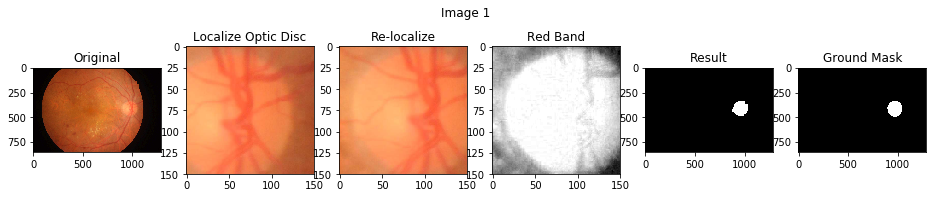

Precision is 90.71 %
Recall/ Sensitivity is 87.59 %
Accuracy is 99.63 %


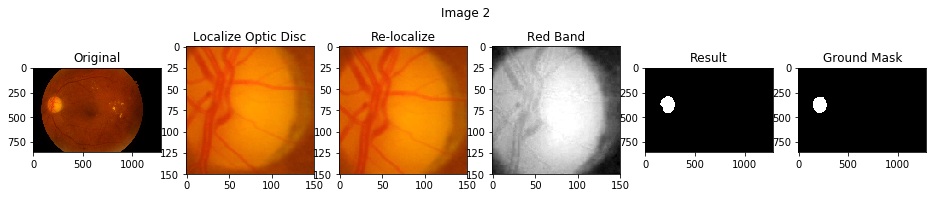

Precision is 88.56 %
Recall/ Sensitivity is 88.52 %
Accuracy is 99.62 %


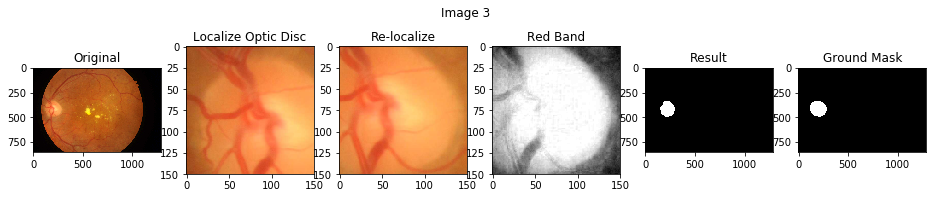

Precision is 90.85 %
Recall/ Sensitivity is 75.02 %
Accuracy is 99.36 %


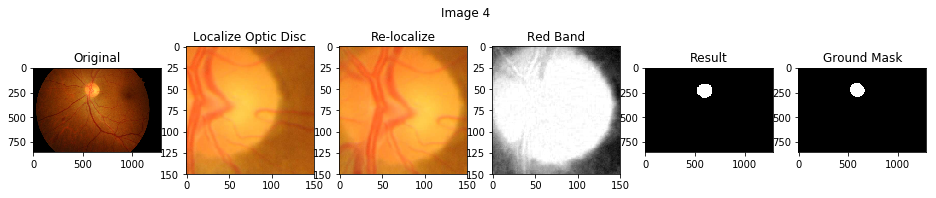

Precision is 86.2 %
Recall/ Sensitivity is 94.95 %
Accuracy is 99.7 %


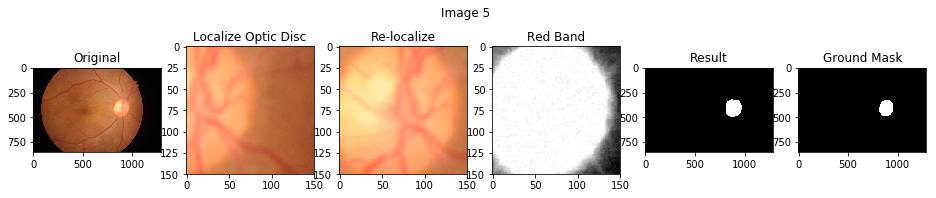

Precision is 81.64 %
Recall/ Sensitivity is 99.76 %
Accuracy is 99.6 %


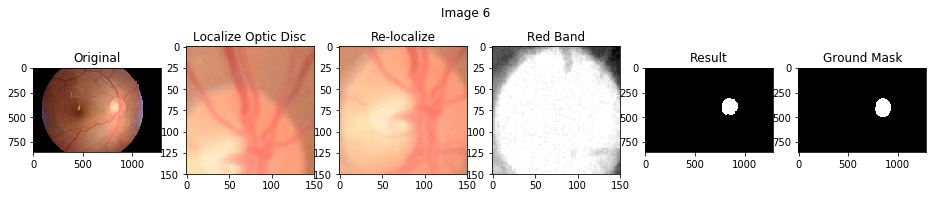

Precision is 95.76 %
Recall/ Sensitivity is 85.74 %
Accuracy is 99.6 %


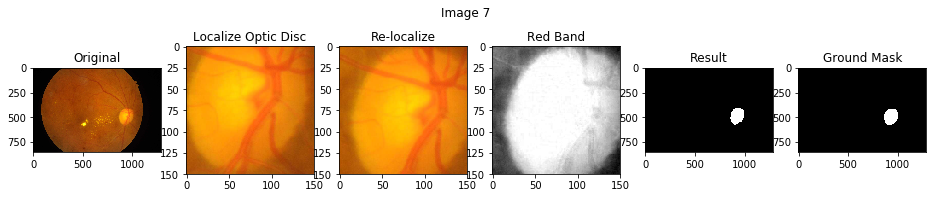

Precision is 91.78 %
Recall/ Sensitivity is 88.8 %
Accuracy is 99.68 %


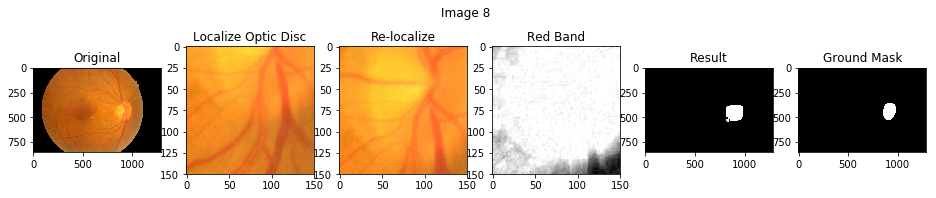

Precision is 64.24 %
Recall/ Sensitivity is 87.04 %
Accuracy is 98.97 %


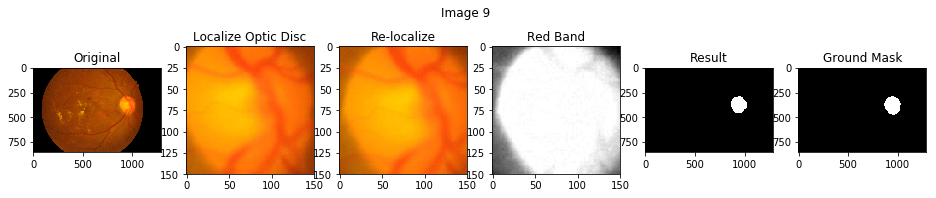

Precision is 95.2 %
Recall/ Sensitivity is 86.28 %
Accuracy is 99.62 %


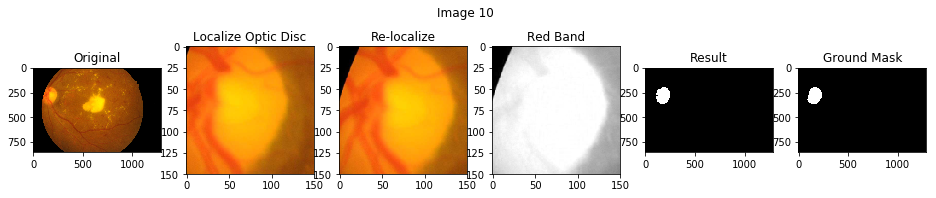

Precision is 88.24 %
Recall/ Sensitivity is 85.37 %
Accuracy is 99.54 %


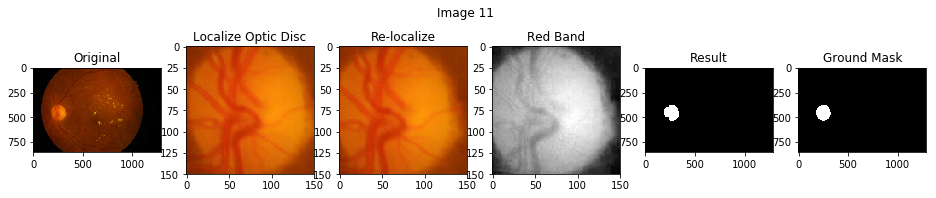

Precision is 86.59 %
Recall/ Sensitivity is 88.89 %
Accuracy is 99.59 %


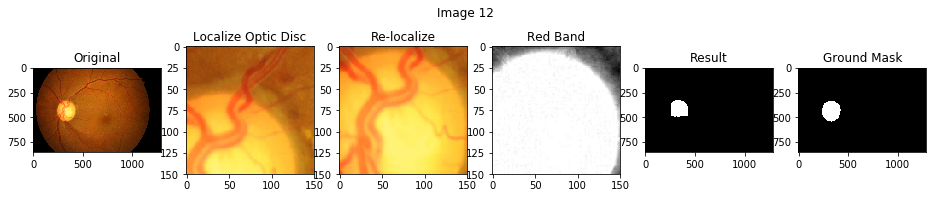

Precision is 89.95 %
Recall/ Sensitivity is 74.79 %
Accuracy is 99.07 %


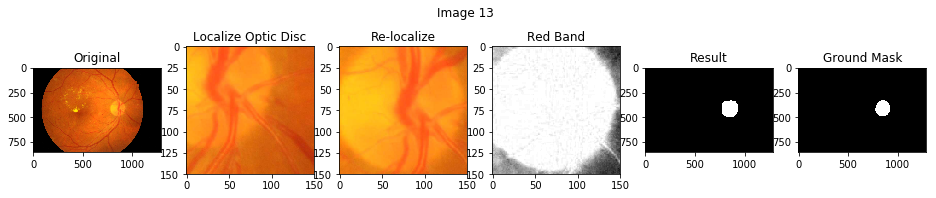

Precision is 80.64 %
Recall/ Sensitivity is 99.33 %
Accuracy is 99.57 %


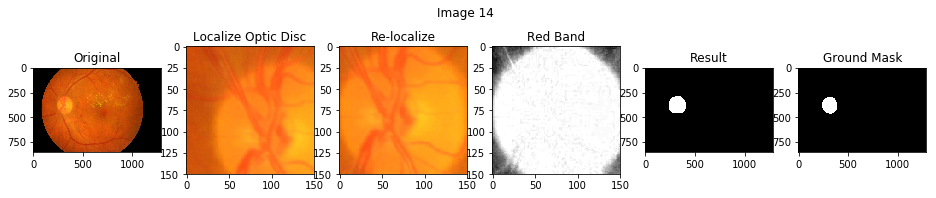

Precision is 80.86 %
Recall/ Sensitivity is 99.5 %
Accuracy is 99.55 %


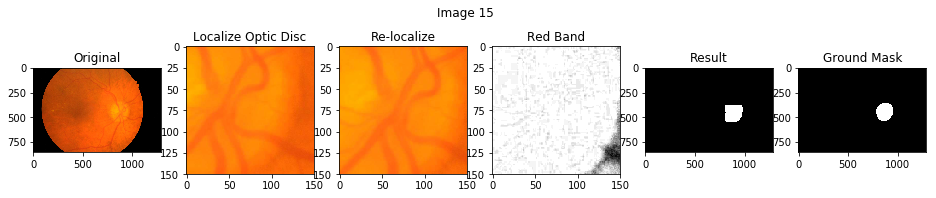

Precision is 77.52 %
Recall/ Sensitivity is 86.0 %
Accuracy is 99.11 %


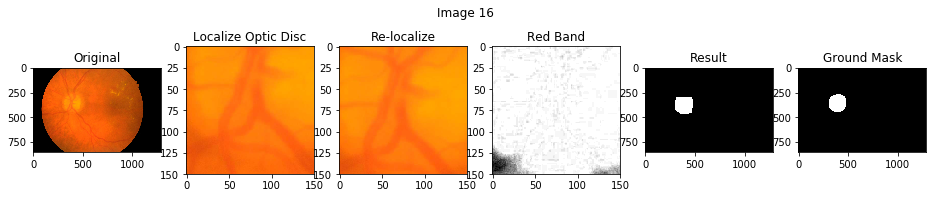

Precision is 80.54 %
Recall/ Sensitivity is 86.16 %
Accuracy is 99.17 %


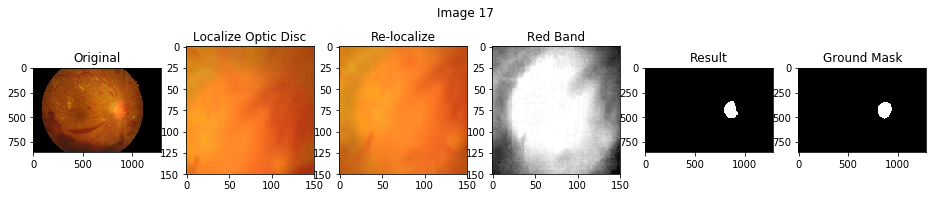

Precision is 88.97 %
Recall/ Sensitivity is 88.24 %
Accuracy is 99.62 %


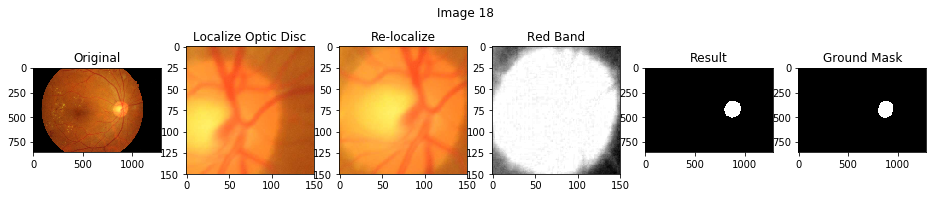

Precision is 90.43 %
Recall/ Sensitivity is 98.94 %
Accuracy is 99.78 %


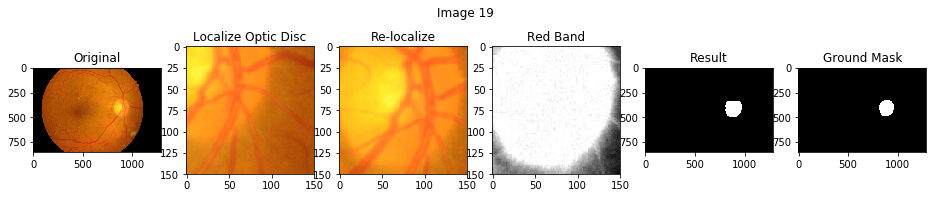

Precision is 81.74 %
Recall/ Sensitivity is 95.84 %
Accuracy is 99.53 %


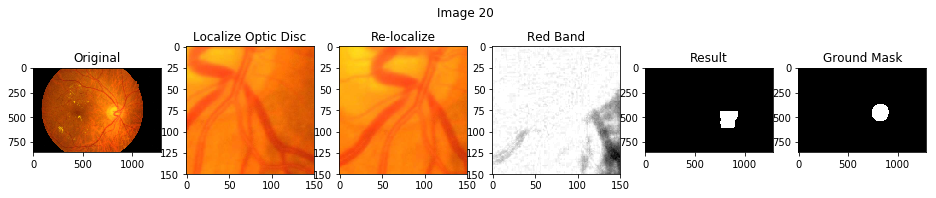

Precision is 51.82 %
Recall/ Sensitivity is 58.87 %
Accuracy is 97.89 %


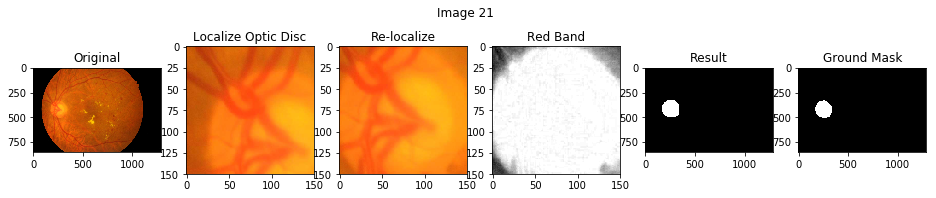

Precision is 90.05 %
Recall/ Sensitivity is 96.78 %
Accuracy is 99.7 %


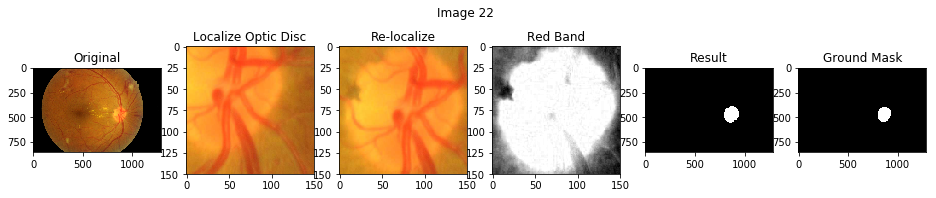

Precision is 83.26 %
Recall/ Sensitivity is 99.89 %
Accuracy is 99.69 %


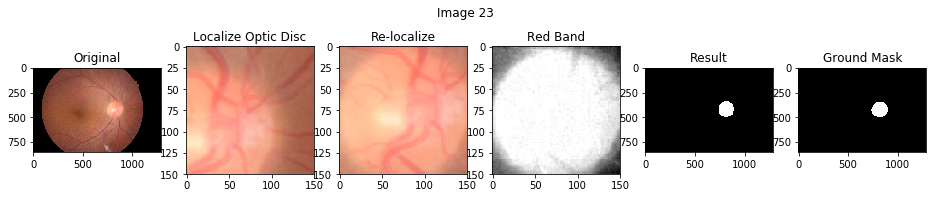

Precision is 95.39 %
Recall/ Sensitivity is 92.95 %
Accuracy is 99.79 %


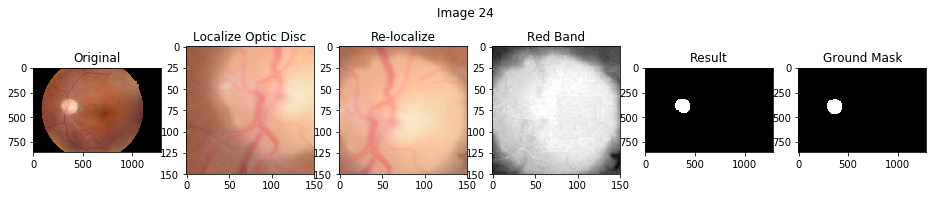

Precision is 90.92 %
Recall/ Sensitivity is 85.73 %
Accuracy is 99.61 %


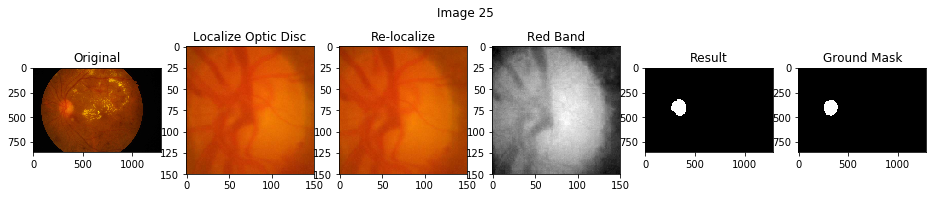

Precision is 82.42 %
Recall/ Sensitivity is 88.77 %
Accuracy is 99.52 %


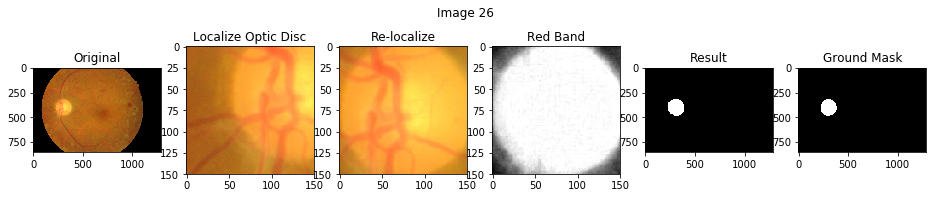

Precision is 93.36 %
Recall/ Sensitivity is 96.83 %
Accuracy is 99.8 %


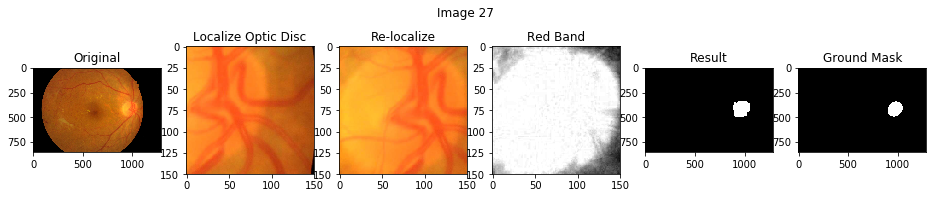

Precision is 75.33 %
Recall/ Sensitivity is 99.77 %
Accuracy is 99.46 %


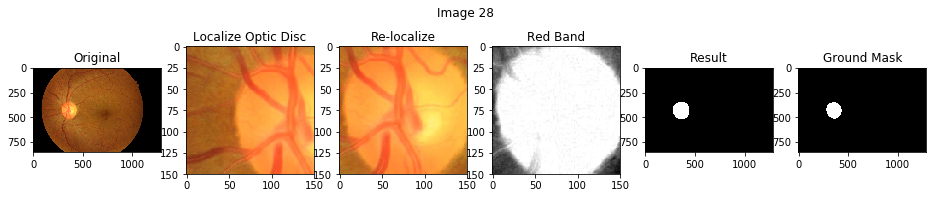

Precision is 84.92 %
Recall/ Sensitivity is 99.95 %
Accuracy is 99.68 %


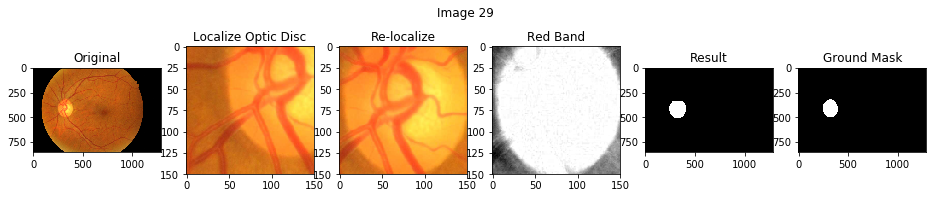

Precision is 85.1 %
Recall/ Sensitivity is 95.36 %
Accuracy is 99.58 %


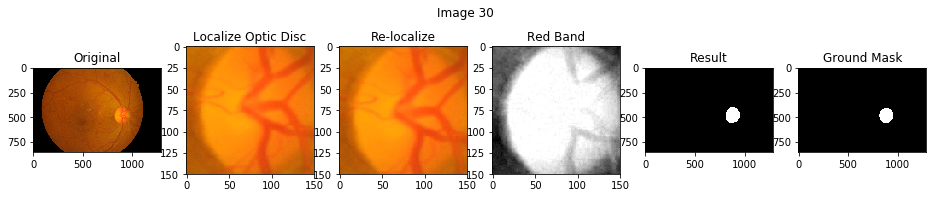

Precision is 90.27 %
Recall/ Sensitivity is 95.91 %
Accuracy is 99.77 %


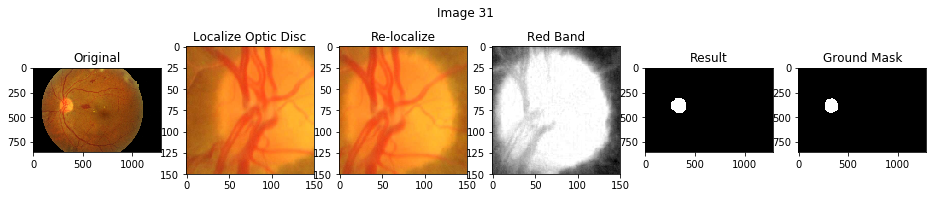

Precision is 81.81 %
Recall/ Sensitivity is 97.63 %
Accuracy is 99.66 %


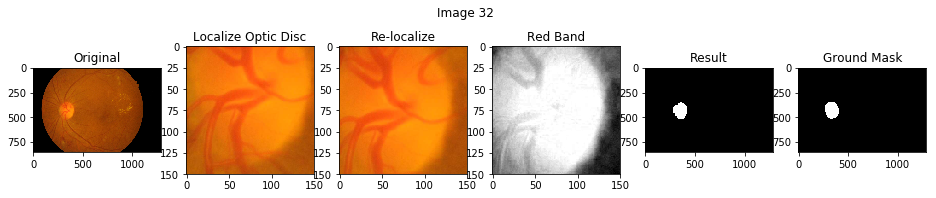

Precision is 86.03 %
Recall/ Sensitivity is 80.8 %
Accuracy is 99.43 %


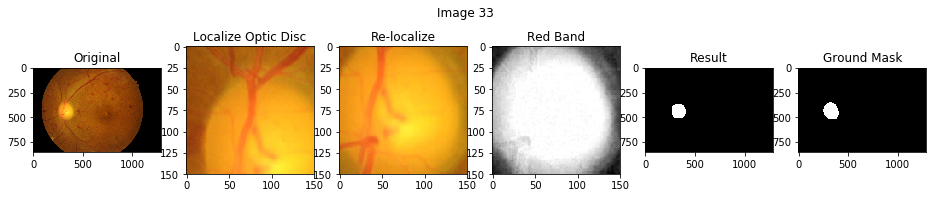

Precision is 98.11 %
Recall/ Sensitivity is 81.82 %
Accuracy is 99.63 %


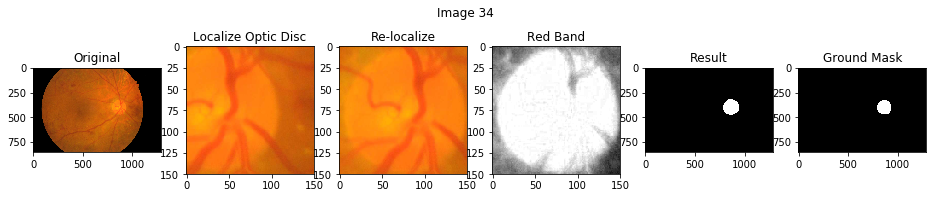

Precision is 82.5 %
Recall/ Sensitivity is 99.34 %
Accuracy is 99.67 %


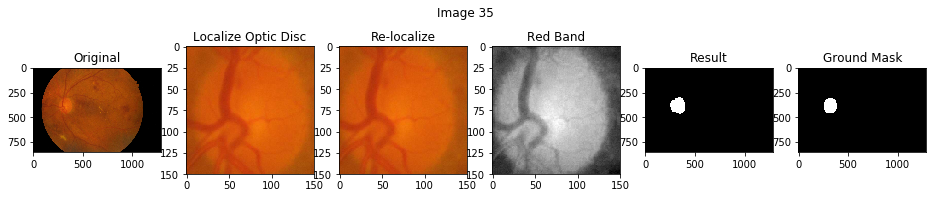

Precision is 84.41 %
Recall/ Sensitivity is 96.77 %
Accuracy is 99.67 %


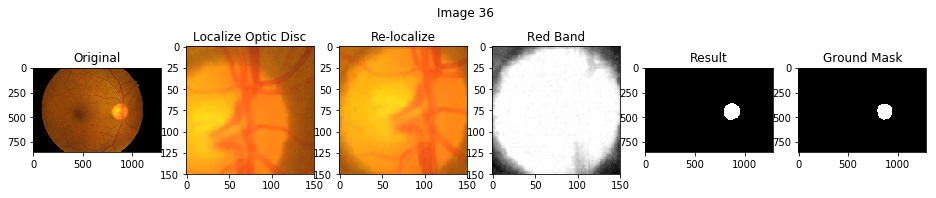

Precision is 89.37 %
Recall/ Sensitivity is 98.97 %
Accuracy is 99.77 %


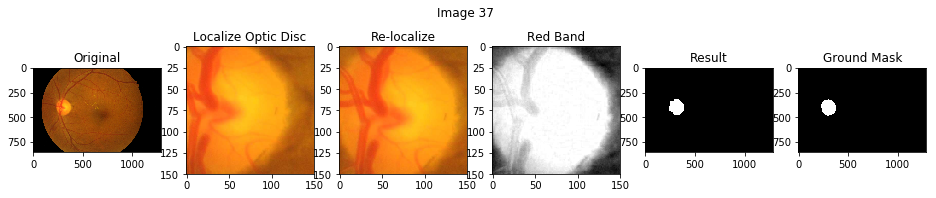

Precision is 90.78 %
Recall/ Sensitivity is 89.9 %
Accuracy is 99.67 %


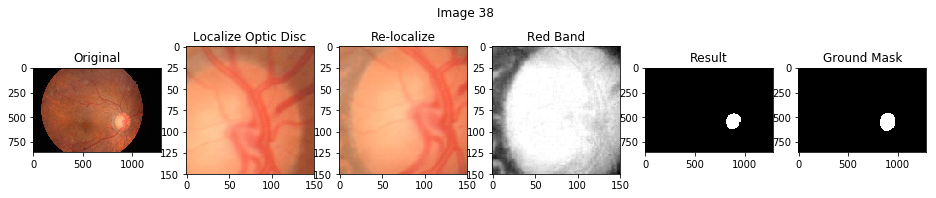

Precision is 95.9 %
Recall/ Sensitivity is 77.4 %
Accuracy is 99.47 %


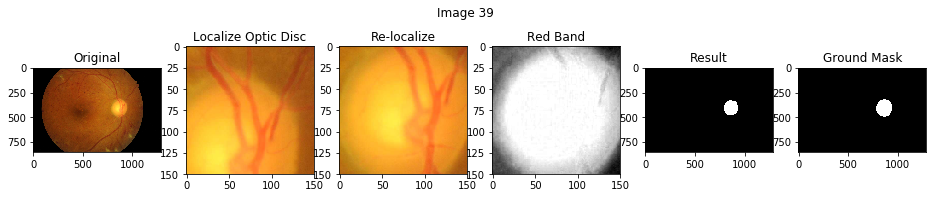

Precision is 100.0 %
Recall/ Sensitivity is 76.66 %
Accuracy is 99.52 %


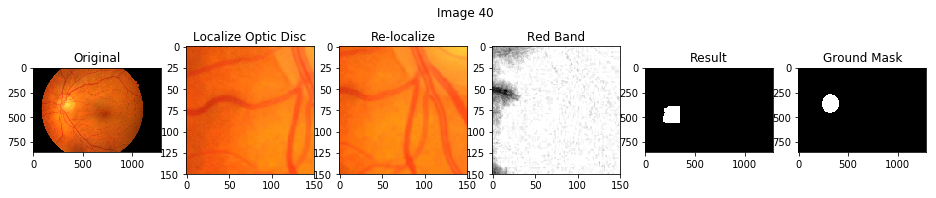

Precision is 22.38 %
Recall/ Sensitivity is 23.82 %
Accuracy is 96.33 %


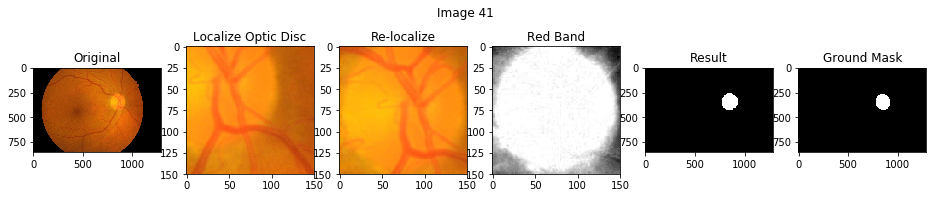

Precision is 86.13 %
Recall/ Sensitivity is 99.24 %
Accuracy is 99.71 %


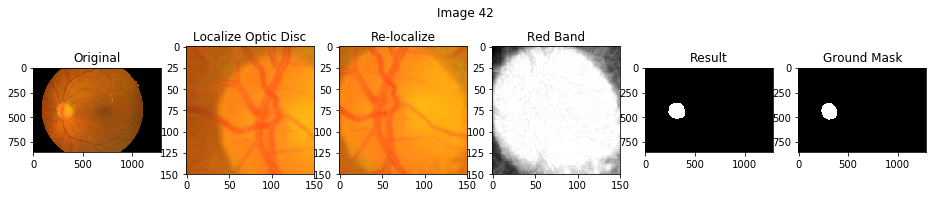

Precision is 92.48 %
Recall/ Sensitivity is 95.84 %
Accuracy is 99.77 %


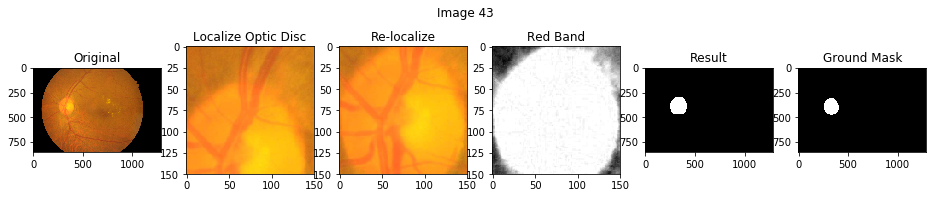

Precision is 80.12 %
Recall/ Sensitivity is 97.97 %
Accuracy is 99.52 %


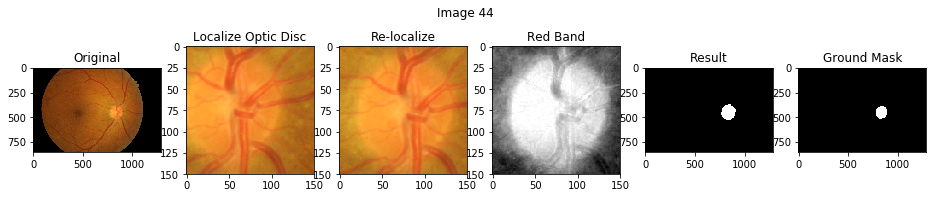

Precision is 65.96 %
Recall/ Sensitivity is 100.0 %
Accuracy is 99.45 %


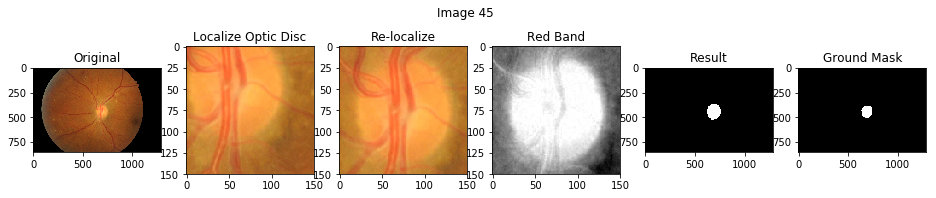

Precision is 63.55 %
Recall/ Sensitivity is 100.0 %
Accuracy is 99.42 %


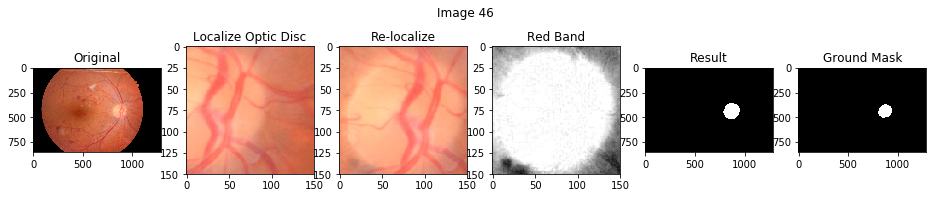

Precision is 70.52 %
Recall/ Sensitivity is 100.0 %
Accuracy is 99.44 %


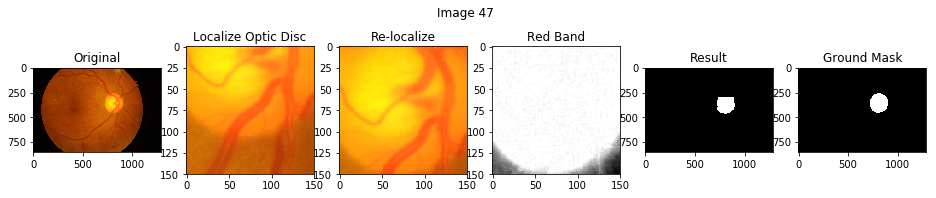

Precision is 92.54 %
Recall/ Sensitivity is 85.17 %
Accuracy is 99.43 %


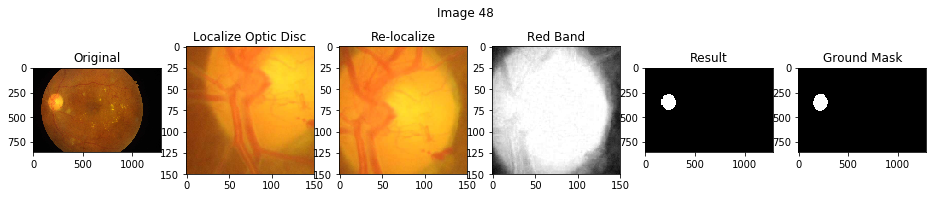

Precision is 91.29 %
Recall/ Sensitivity is 84.72 %
Accuracy is 99.58 %


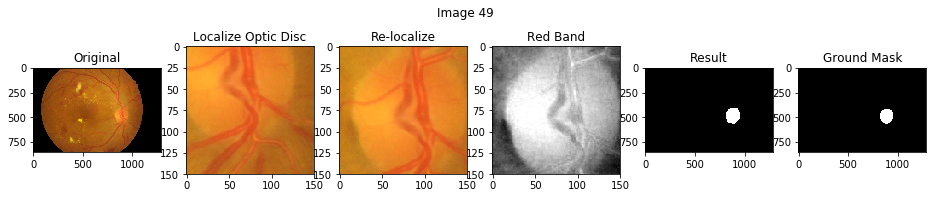

Precision is 83.14 %
Recall/ Sensitivity is 97.27 %
Accuracy is 99.67 %


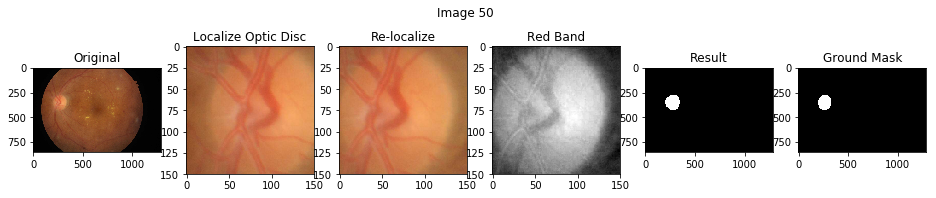

Precision is 87.49 %
Recall/ Sensitivity is 95.14 %
Accuracy is 99.72 %


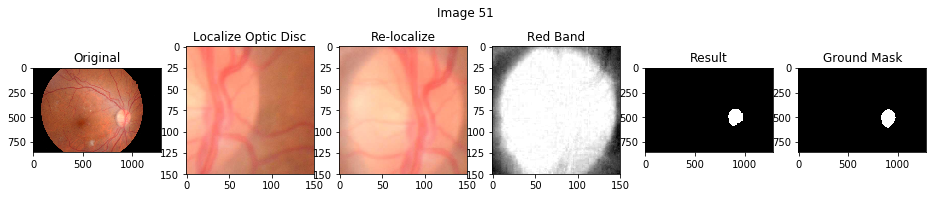

Precision is 91.96 %
Recall/ Sensitivity is 89.5 %
Accuracy is 99.66 %


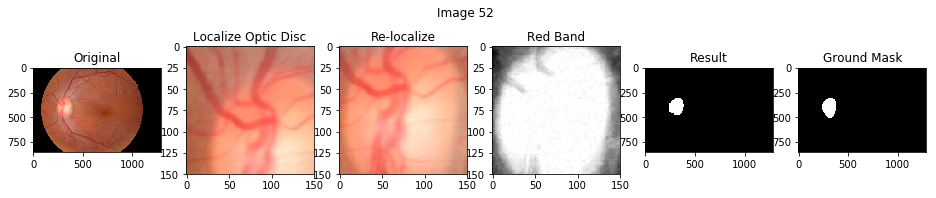

Precision is 94.87 %
Recall/ Sensitivity is 87.64 %
Accuracy is 99.66 %


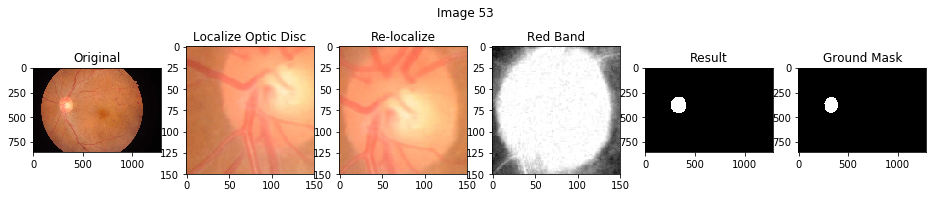

Precision is 83.78 %
Recall/ Sensitivity is 99.92 %
Accuracy is 99.7 %


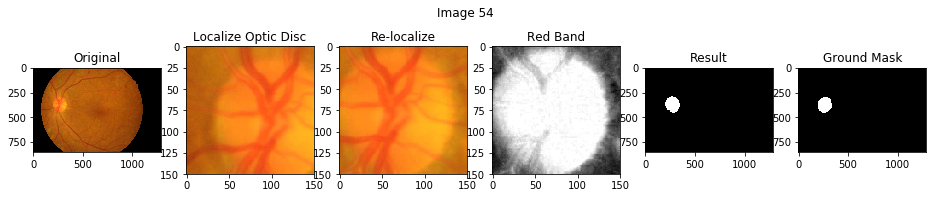

Precision is 87.94 %
Recall/ Sensitivity is 91.83 %
Accuracy is 99.66 %

----------------------------------------------------------------------------------------
Average Preciscion is 84.38 %
Average Recall / Sensitivity is 89.91 %
Average Accuracy is 99.48 %


In [16]:
# window size: 150*150
size = 150
row = img_list[0].shape[0]-size
col = img_list[0].shape[1]-size
# store accuracy
precis_list = []
recall_list = []
accuracy_list = []

for k in range(len(img_list)):
    # store highest correlation
    highest_c = 0
    # iterate pixel with a stride of 5
    for i in range(0, row-size, 5):
        for j in range(0, col-size, 5):
            # plot histogram of each color band
            hist_r = gen_hist_index(img_list[k], i, j, size, 0)
            hist_g = gen_hist_index(img_list[k], i, j, size, 1)
            hist_b = gen_hist_index(img_list[k], i, j, size, 2)
            # calculate correlation between each window to the template window
            c_r = cv2.compareHist(hist_r, mean_hist_r, cv2.HISTCMP_CORREL)
            c_g = cv2.compareHist(hist_g, mean_hist_g, cv2.HISTCMP_CORREL)
            c_b = cv2.compareHist(hist_b, mean_hist_b, cv2.HISTCMP_CORREL)
            # use the equation on the reference
            c = 0.5*c_r + 0.2*c_g + 0.1*c_b
            # find the highest correlation window
            if c > highest_c:
                highest_c = c
                a = i
                b = j
    
    # find the center of the thresholded image's contour, which is the round optic disc
    result = thresh(img_list[k], a, b, size)
    # coordinate of the center of the optic disc
    cX, cY = find_center(result)
    # find center twice
    result1 = thresh(img_list[k], cY-75, cX-75, size)
    cX1, cY1 = find_center(result1)

    result2 = thresh(img_list[k], cY1-75, cX1-75, size)

    # evaluation matrix
    precision_rate, recall_rate, accuracy_rate, final_result = evaluation(result2, masks[k])

    # show the segmented image and compare each process
    fig, ax = plt.subplots(figsize=(16,3),ncols=6,nrows=1)
    fig.suptitle('Image '+str(k+1))
    ax[0].imshow(img_list[k])
    ax[0].set_title('Original')
    ax[1].imshow(img_list[k][a:a+size, b:b+size])
    ax[1].set_title('Localize Optic Disc')
    ax[2].imshow(img_list[k][cY1-75:cY1+75, cX1-75:cX1+75])
    ax[2].set_title('Re-localize')
    ax[3].imshow(img_list[k][cY1-75:cY1+75, cX1-75:cX1+75, 0], cmap='gray')
    ax[3].set_title('Red Band')
    ax[4].imshow(final_result, cmap='gray')
    ax[4].set_title('Result')
    ax[5].imshow(masks[k], cmap='gray')
    ax[5].set_title('Ground Mask')
    plt.show()

    # show accuracy
    print("Precision is",precision_rate,"%")
    print("Recall/ Sensitivity is",recall_rate,"%")
    print("Accuracy is",accuracy_rate,"%")
    precis_list.append(precision_rate)
    recall_list.append(recall_rate)
    accuracy_list.append(accuracy_rate)


avg_precis = sum(precis_list) / len(precis_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_accuracy = sum(accuracy_list) / len(accuracy_list)

print("\n----------------------------------------------------------------------------------------")
print("Average Preciscion is",round(avg_precis, 2),"%")
print("Average Recall / Sensitivity is",round(avg_recall, 2),"%")
print("Average Accuracy is",round(avg_accuracy, 2),"%")
